In [9]:
import numpy as np
import cv2

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import torch.backends.cudnn as cudnn
import torchvision

from PIL import Image
from utils import select_device, draw_gaze
# from PIL import Image, ImageOps

from face_detection import RetinaFace
from model import L2CS

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getArch(arch,bins):
    # Base network structure
    if arch == 'ResNet18':
        model = L2CS( torchvision.models.resnet.BasicBlock,[2, 2,  2, 2], bins)
    elif arch == 'ResNet34':
        model = L2CS( torchvision.models.resnet.BasicBlock,[3, 4,  6, 3], bins)
    elif arch == 'ResNet101':
        model = L2CS( torchvision.models.resnet.Bottleneck,[3, 4, 23, 3], bins)
    elif arch == 'ResNet152':
        model = L2CS( torchvision.models.resnet.Bottleneck,[3, 8, 36, 3], bins)
    else:
        if arch != 'ResNet50':
            print('Invalid value for architecture is passed! '
                'The default value of ResNet50 will be used instead!')
        model = L2CS( torchvision.models.resnet.Bottleneck, [3, 4, 6,  3], bins)
    return model

In [5]:
cudnn.enabled = True
arch='ResNet50'
batch_size = 1
cam = 0
gpu = select_device('0', batch_size=batch_size)
snapshot_path = 'models/L2CSNet/Gaze360/L2CSNet_gaze360.pkl'

In [6]:
transformations = transforms.Compose([
        transforms.Resize(448),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

In [7]:
model=getArch(arch, 90)
print('Loading snapshot')
saved_state_dict = torch.load(snapshot_path)
model.load_state_dict(saved_state_dict)
model.cuda(gpu)
model.eval()

Loading snapshot.


L2CS(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [8]:
softmax = nn.Softmax(dim=1)
detector = RetinaFace(gpu_id=0)
idx_tensor = [idx for idx in range(90)]
idx_tensor = torch.FloatTensor(idx_tensor).cuda(gpu)
x=0

In [59]:
def detect_face_and_predict_gaze(img):
    img_out = img.copy()
    with torch.no_grad():
        faces = detector(img)
        if faces is not None:
            # print("Faces Detected")
            face = faces[0]
            print(face)
            box, landmarks, score = face
            print(box, landmarks, score) 
            if score > .95:
                # print("Score > 0.95")
                x_min=int(box[0])
                if x_min < 0:
                    x_min = 0
                y_min=int(box[1])
                if y_min < 0:
                    y_min = 0
                x_max=int(box[2])
                y_max=int(box[3])
                bbox_width = x_max - x_min
                bbox_height = y_max - y_min

                img = img[y_min:y_max, x_min:x_max]
                img = cv2.resize(img, (224, 224))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                im_pil = Image.fromarray(img)
                img = transformations(im_pil)
                img  = Variable(img).cuda(gpu)
                img  = img.unsqueeze(0)

                gaze_pitch, gaze_yaw = model(img)
                
                pitch_predicted = softmax(gaze_pitch)
                yaw_predicted = softmax(gaze_yaw)
                
                # Get continuous predictions in degrees.
                pitch_predicted = torch.sum(pitch_predicted.data[0] * idx_tensor) * 4 - 180
                yaw_predicted = torch.sum(yaw_predicted.data[0] * idx_tensor) * 4 - 180
                
                pitch_predicted = pitch_predicted.cpu().detach().numpy()* np.pi/180.0
                yaw_predicted = yaw_predicted.cpu().detach().numpy()* np.pi/180.0

                print(pitch_predicted, yaw_predicted)
                img_out = draw_gaze(x_min,y_min,bbox_width, bbox_height, img_out, (pitch_predicted,yaw_predicted), color=(0,0,255))

        return pitch_predicted, yaw_predicted, img_out
            # return img

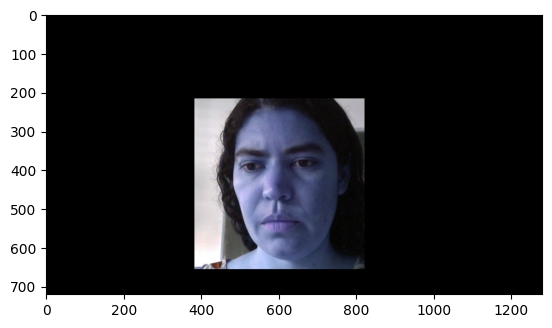

In [64]:
img_path = '../data/MPIIFaceGaze/p00/day01/0030.jpg'
img = cv2.imread(img_path)
plt.imshow(img)

In [65]:
pitch, yaw, img_out = detect_face_and_predict_gaze(img)
print(pitch, yaw)

(array([478.39465, 234.07129, 750.7694 , 645.0766 ], dtype=float32), array([[533.4343 , 390.43286],
       [665.15686, 387.00946],
       [589.56805, 464.5775 ],
       [545.0977 , 537.1962 ],
       [658.4523 , 534.07245]], dtype=float32), 0.998432)
[478.39465 234.07129 750.7694  645.0766 ] [[533.4343  390.43286]
 [665.15686 387.00946]
 [589.56805 464.5775 ]
 [545.0977  537.1962 ]
 [658.4523  534.07245]] 0.998432
0.18516612848379232 -0.17516489332610877
0.18516612848379232 -0.17516489332610877


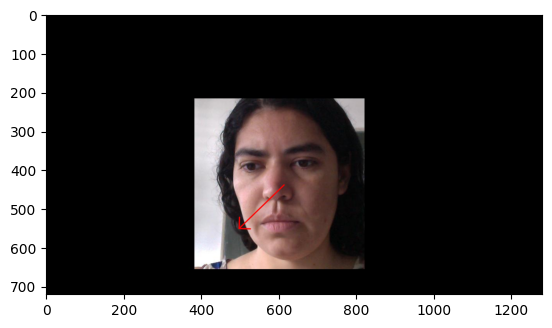

In [67]:
plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))